In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

%matplotlib inline

import warnings
warnings.filterwarnings(action="ignore")

In [4]:
# define the target variable
target_feature = "SalePrice"

# Load the dataset
train = pd.read_csv('C:\\Users\\ajroy\\OneDrive\\Desktop\\mypython.py\\house_price_predection\\data\\USA Housing Dataset.csv')
test = pd.read_csv('C:\\Users\\ajroy\\OneDrive\\Desktop\\mypython.py\\house_price_predection\\data\\USA Housing Dataset.csv')
print(f'train.shape: {train.shape}')
print(f'test.shape : {test.shape}')

train.shape: (4140, 18)
test.shape : (4140, 18)


In [5]:
test.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-09 00:00:00,376000.0,3.0,2.00,1340,1384,3.0,0,0,3,1340,0,2008,0,9245-9249 Fremont Ave N,Seattle,WA 98103,USA
1,2014-05-09 00:00:00,800000.0,4.0,3.25,3540,159430,2.0,0,0,3,3540,0,2007,0,33001 NE 24th St,Carnation,WA 98014,USA
2,2014-05-09 00:00:00,2238888.0,5.0,6.50,7270,130017,2.0,0,0,3,6420,850,2010,0,7070 270th Pl SE,Issaquah,WA 98029,USA
3,2014-05-09 00:00:00,324000.0,3.0,2.25,998,904,2.0,0,0,3,798,200,2007,0,820 NW 95th St,Seattle,WA 98117,USA
4,2014-05-10 00:00:00,549900.0,5.0,2.75,3060,7015,1.0,0,0,5,1600,1460,1979,0,10834 31st Ave SW,Seattle,WA 98146,USA


In [6]:
train.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-09 00:00:00,376000.0,3.0,2.00,1340,1384,3.0,0,0,3,1340,0,2008,0,9245-9249 Fremont Ave N,Seattle,WA 98103,USA
1,2014-05-09 00:00:00,800000.0,4.0,3.25,3540,159430,2.0,0,0,3,3540,0,2007,0,33001 NE 24th St,Carnation,WA 98014,USA
2,2014-05-09 00:00:00,2238888.0,5.0,6.50,7270,130017,2.0,0,0,3,6420,850,2010,0,7070 270th Pl SE,Issaquah,WA 98029,USA
3,2014-05-09 00:00:00,324000.0,3.0,2.25,998,904,2.0,0,0,3,798,200,2007,0,820 NW 95th St,Seattle,WA 98117,USA
4,2014-05-10 00:00:00,549900.0,5.0,2.75,3060,7015,1.0,0,0,5,1600,1460,1979,0,10834 31st Ave SW,Seattle,WA 98146,USA


In [7]:


def split_data_X_y(df, target_feature):
    df = df.copy()
    if target_feature not in df.columns:
        raise KeyError(f"target_feature '{target_feature}' not in DataFrame columns")
    y = df[target_feature]
    X = df.drop(columns=[target_feature])
    return X, y

def split_data_train_test(df, target_feature, test_size=0.2, stratify=False):
    X, y = split_data_X_y(df, target_feature)
    strat = y if stratify else None
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=strat
    )
    return X_train, X_test, y_train, y_test

def get_categorical_features(df):
    # return only object and category types (commonly used for categorical)
    return df.select_dtypes(include=['object','category']).columns

def get_numerical_features(df):
    return df.select_dtypes(include=[np.number]).columns

def show_dtypes(df):
    pd.set_option('display.max_colwidth', None)
    # group column names by dtype
    groups = df.columns.to_series().groupby(df.dtypes).agg(list)
    out = pd.DataFrame({
        'dtype': groups.index.astype(str),
        '# columns': groups.apply(len).values,
        'columns': groups.values
    })
    return out.style.set_properties(subset=['columns'], **{'text-align':'left'})

def generate_summary_table(df, nunique_threshold=100):
    num_cols = set(get_numerical_features(df))
    rows = []
    for col in df.columns:
        s = df[col]
        is_num = col in num_cols
        uniq = s.nunique(dropna=False)
        mode_val = s.mode()[0] if not s.mode().empty else np.nan
        mode_count = s.value_counts(dropna=False).max() if not s.value_counts(dropna=False).empty else 0
        mode_pct = round(mode_count * 100 / len(df), 1) if len(df) > 0 else 0

        row = {
            'column': col,
            'dtype': s.dtype,
            'count': s.count(),
            'mean': round(s.mean(), 1) if is_num else '',
            'std': round(s.std(), 1) if is_num else '',
            'min': round(s.min(), 1) if is_num else '',
            '25%': round(s.quantile(0.25), 1) if is_num else '',
            '50%': round(s.median(), 1) if is_num else '',
            '75%': round(s.quantile(0.75), 1) if is_num else '',
            'max': round(s.max(), 1) if is_num else '',
            'nunique': uniq,
            'unique': list(s.unique()) if uniq < nunique_threshold else '',
            'mode': mode_val,
            'mode #': int(mode_count),
            'mode %': mode_pct,
            'null #': int(s.isnull().sum()),
            'null %': round(s.isnull().mean() * 100, 1)
        }
        rows.append(row)

    summary_table = pd.DataFrame(rows)
    summary_table = summary_table.sort_values(by='dtype')
    return summary_table

def plot_missing_values(nan_df, figsize=(12,4)):
    # Expect nan_df to have columns ['column', 'null %']
    plt.figure(figsize=figsize)
    sns.barplot(x='column', y='null %', data=nan_df)
    plt.title("Percentage of missing values in data")
    plt.xlabel("Data columns")
    plt.ylabel("Percentage %")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


In [8]:
show_dtypes(train)

,dtype,# columns,columns
0,int64,9,"['sqft_living', 'sqft_lot', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']"
1,float64,4,"['price', 'bedrooms', 'bathrooms', 'floors']"
2,object,5,"['date', 'street', 'city', 'statezip', 'country']"


In [9]:
categorical_features = get_categorical_features(train)
numerical_features   = get_numerical_features(train)

# Format and print the categorical features
print(f"Categorical Features: ({len(categorical_features)})")
print("  " + ", ".join(categorical_features))

# Add a separator for better readability
print("\n" + "-"*40 + "\n")

# Format and print the numerical features
print(f"Numerical Features: ({len(numerical_features)})")
print("  " + ", ".join(numerical_features))

Categorical Features: (5)
  date, street, city, statezip, country

----------------------------------------

Numerical Features: (13)
  price, bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, sqft_above, sqft_basement, yr_built, yr_renovated


In [10]:
train[numerical_features].head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
0,376000.0,3.0,2.00,1340,1384,3.0,0,0,3,1340,0,2008,0
1,800000.0,4.0,3.25,3540,159430,2.0,0,0,3,3540,0,2007,0
2,2238888.0,5.0,6.50,7270,130017,2.0,0,0,3,6420,850,2010,0
3,324000.0,3.0,2.25,998,904,2.0,0,0,3,798,200,2007,0
4,549900.0,5.0,2.75,3060,7015,1.0,0,0,5,1600,1460,1979,0


In [11]:
train[categorical_features].head()

,date,street,city,statezip,country
0,2014-05-09 00:00:00,9245-9249 Fremont Ave N,Seattle,WA 98103,USA
1,2014-05-09 00:00:00,33001 NE 24th St,Carnation,WA 98014,USA
2,2014-05-09 00:00:00,7070 270th Pl SE,Issaquah,WA 98029,USA
3,2014-05-09 00:00:00,820 NW 95th St,Seattle,WA 98117,USA
4,2014-05-10 00:00:00,10834 31st Ave SW,Seattle,WA 98146,USA


In [12]:
# Check for duplicate rows
duplicate_rows = train[train.duplicated()]
print("Duplicate rows:")
print(duplicate_rows)

Duplicate rows:
Empty DataFrame
Columns: [date, price, bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, sqft_above, sqft_basement, yr_built, yr_renovated, street, city, statezip, country]
Index: []


In [13]:
generate_summary_table(train[numerical_features])

,column,dtype,count,mean,std,min,25%,50%,75%,max,nunique,unique,mode,mode #,mode %,null #,null %
3,sqft_living,int64,4140,2143.6,957.5,370.0,1470.0,1980.0,2620.0,10040.0,549,,1720.0,31,0.7,0,0.0
4,sqft_lot,int64,4140,14697.6,35876.8,638.0,5000.0,7676.0,11000.0,1074218.0,2856,,5000.0,69,1.7,0,0.0
6,waterfront,int64,4140,0.0,0.1,0.0,0.0,0.0,0.0,1.0,2,"[0, 1]",0.0,4109,99.3,0,0.0
7,view,int64,4140,0.2,0.8,0.0,0.0,0.0,0.0,4.0,5,"[0, 4, 1, 2, 3]",0.0,3722,89.9,0,0.0
8,condition,int64,4140,3.5,0.7,1.0,3.0,3.0,4.0,5.0,5,"[3, 5, 4, 2, 1]",3.0,2596,62.7,0,0.0
9,sqft_above,int64,4140,1831.4,861.4,370.0,1190.0,1600.0,2310.0,8020.0,491,,1200.0,43,1.0,0,0.0
10,sqft_basement,int64,4140,312.3,464.3,0.0,0.0,0.0,602.5,4820.0,205,,0.0,2476,59.8,0,0.0
11,yr_built,int64,4140,1970.8,29.8,1900.0,1951.0,1976.0,1997.0,2014.0,115,,2005.0,96,2.3,0,0.0
12,yr_renovated,int64,4140,808.4,979.4,0.0,0.0,0.0,1999.0,2014.0,60,"[0, 2007, 2003, 2006, 1970, 2009, 1990, 1994, 2000, 1983, 2001, 2014, 1923, 1956, 1997, 1989, 1981, 1912, 2004, 1979, 1984, 2011, 1982, 1999, 2002, 1969, 2012, 2013, 1972, 2008, 2005, 1988, 1998, 1985, 1974, 1971, 1996, 2010, 1954, 1963, 1992, 1945, 1993, 1968, 1995, 1986, 1934, 1953, 1966, 1955, 1958, 1987, 1960, 1978, 1980, 1948, 1991, 1913, 1977, 1975]",0.0,2462,59.5,0,0.0
0,price,float64,4140,553062.9,583686.5,0.0,320000.0,460000.0,659125.0,26590000.0,1625,,0.0,49,1.2,0,0.0


In [14]:
generate_summary_table(train[categorical_features])

,column,dtype,count,mean,std,min,25%,50%,75%,max,nunique,unique,mode,mode #,mode %,null #,null %
0,date,object,4140,,,,,,,,68,"[2014-05-09 00:00:00, 2014-05-10 00:00:00, 2014-05-11 00:00:00, 2014-05-12 00:00:00, 2014-05-13 00:00:00, 2014-05-14 00:00:00, 2014-05-15 00:00:00, 2014-05-16 00:00:00, 2014-05-17 00:00:00, 2014-05-18 00:00:00, 2014-05-19 00:00:00, 2014-05-20 00:00:00, 2014-05-21 00:00:00, 2014-05-22 00:00:00, 2014-05-23 00:00:00, 2014-05-24 00:00:00, 2014-05-25 00:00:00, 2014-05-26 00:00:00, 2014-05-27 00:00:00, 2014-05-28 00:00:00, 2014-05-29 00:00:00, 2014-05-30 00:00:00, 2014-05-31 00:00:00, 2014-06-01 00:00:00, 2014-06-02 00:00:00, 2014-06-03 00:00:00, 2014-06-04 00:00:00, 2014-06-05 00:00:00, 2014-06-06 00:00:00, 2014-06-07 00:00:00, 2014-06-08 00:00:00, 2014-06-09 00:00:00, 2014-06-10 00:00:00, 2014-06-11 00:00:00, 2014-06-12 00:00:00, 2014-06-13 00:00:00, 2014-06-14 00:00:00, 2014-06-15 00:00:00, 2014-06-16 00:00:00, 2014-06-17 00:00:00, 2014-06-18 00:00:00, 2014-06-19 00:00:00, 2014-06-20 00:00:00, 2014-06-21 00:00:00, 2014-06-22 00:00:00, 2014-06-23 00:00:00, 2014-06-24 00:00:00, 2014-06-25 00:00:00, 2014-06-26 00:00:00, 2014-06-27 00:00:00, 2014-06-28 00:00:00, 2014-06-29 00:00:00, 2014-06-30 00:00:00, 2014-07-01 00:00:00, 2014-07-02 00:00:00, 2014-07-03 00:00:00, 2014-07-04 00:00:00, 2014-07-05 00:00:00, 2014-07-06 00:00:00, 2014-07-07 00:00:00, 2014-07-08 00:00:00, 2014-07-09 00:00:00, 2014-07-10 00:00:00, 2014-05-02 00:00:00, 2014-05-08 00:00:00, 2014-05-06 00:00:00, 2014-05-05 00:00:00, 2014-05-07 00:00:00]",2014-06-23 00:00:00,142,3.4,0,0.0
1,street,object,4140,,,,,,,,4079,,2520 Mulberry Walk NE,4,0.1,0,0.0
2,city,object,4140,,,,,,,,43,"[Seattle, Carnation, Issaquah, Maple Valley, Kent, Redmond, Clyde Hill, Shoreline, Mercer Island, Auburn, Bellevue, Duvall, Renton, Sammamish, Woodinville, Kirkland, Burien, Federal Way, Normandy Park, Vashon, Kenmore, Yarrow Point, SeaTac, Newcastle, Covington, Lake Forest Park, Snoqualmie, Des Moines, Fall City, Ravensdale, Tukwila, North Bend, Medina, Bothell, Enumclaw, Snoqualmie Pass, Pacific, Black Diamond, Beaux Arts Village, Algona, Preston, Milton, Skykomish]",Seattle,1415,34.2,0,0.0
3,statezip,object,4140,,,,,,,,77,"[WA 98103, WA 98014, WA 98029, WA 98117, WA 98146, WA 98038, WA 98031, WA 98136, WA 98122, WA 98053, WA 98105, WA 98004, WA 98112, WA 98155, WA 98126, WA 98040, WA 98092, WA 98005, WA 98019, WA 98118, WA 98006, WA 98178, WA 98106, WA 98116, WA 98058, WA 98074, WA 98077, WA 98033, WA 98115, WA 98052, WA 98168, WA 98107, WA 98042, WA 98027, WA 98125, WA 98072, WA 98166, WA 98003, WA 98109, WA 98177, WA 98034, WA 98070, WA 98199, WA 98028, WA 98023, WA 98133, WA 98056, WA 98030, WA 98008, WA 98108, WA 98102, WA 98001, WA 98075, WA 98188, WA 98007, WA 98065, WA 98059, WA 98198, WA 98002, WA 98144, WA 98024, WA 98051, WA 98055, WA 98045, WA 98039, WA 98119, WA 98032, WA 98011, WA 98022, WA 98148, WA 98068, WA 98047, WA 98057, WA 98010, WA 98050, WA 98354, WA 98288]",WA 98103,128,3.1,0,0.0
4,country,object,4140,,,,,,,,1,[USA],USA,4140,100.0,0,0.0


In [15]:
# show columns with null more than 5%
train_info = generate_summary_table(train)
nan_df = train_info[train_info['null %'] >= 5][['column', 'null %']]
if nan_df.shape[0] > 0: plot_missing_values(nan_df)

In [16]:
for col in train.columns:
    print(f"\nColumn: {col}")
    print(sorted(train[col].dropna().unique())[:50])  # Sirf first 50 values


Column: date
['2014-05-02 00:00:00', '2014-05-05 00:00:00', '2014-05-06 00:00:00', '2014-05-07 00:00:00', '2014-05-08 00:00:00', '2014-05-09 00:00:00', '2014-05-10 00:00:00', '2014-05-11 00:00:00', '2014-05-12 00:00:00', '2014-05-13 00:00:00', '2014-05-14 00:00:00', '2014-05-15 00:00:00', '2014-05-16 00:00:00', '2014-05-17 00:00:00', '2014-05-18 00:00:00', '2014-05-19 00:00:00', '2014-05-20 00:00:00', '2014-05-21 00:00:00', '2014-05-22 00:00:00', '2014-05-23 00:00:00', '2014-05-24 00:00:00', '2014-05-25 00:00:00', '2014-05-26 00:00:00', '2014-05-27 00:00:00', '2014-05-28 00:00:00', '2014-05-29 00:00:00', '2014-05-30 00:00:00', '2014-05-31 00:00:00', '2014-06-01 00:00:00', '2014-06-02 00:00:00', '2014-06-03 00:00:00', '2014-06-04 00:00:00', '2014-06-05 00:00:00', '2014-06-06 00:00:00', '2014-06-07 00:00:00', '2014-06-08 00:00:00', '2014-06-09 00:00:00', '2014-06-10 00:00:00', '2014-06-11 00:00:00', '2014-06-12 00:00:00', '2014-06-13 00:00:00', '2014-06-14 00:00:00', '2014-06-15 00:00:0

In [17]:
(train.isnull().mean() * 100).round(2)


date             0.0
price            0.0
bedrooms         0.0
bathrooms        0.0
sqft_living      0.0
sqft_lot         0.0
floors           0.0
waterfront       0.0
view             0.0
condition        0.0
sqft_above       0.0
sqft_basement    0.0
yr_built         0.0
yr_renovated     0.0
street           0.0
city             0.0
statezip         0.0
country          0.0
dtype: float64

In [18]:
categorical_features = get_categorical_features(train)
numerical_features   = get_numerical_features(train)

# Format and print the categorical features
print(f"Categorical Features: ({len(categorical_features)})")
print("  " + ", ".join(categorical_features))

# Add a separator for better readability
print("\n" + "-"*40 + "\n")

# Format and print the numerical features
print(f"Numerical Features: ({len(numerical_features)})")
print("  " + ", ".join(numerical_features))

Categorical Features: (5)
  date, street, city, statezip, country

----------------------------------------

Numerical Features: (13)
  price, bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, sqft_above, sqft_basement, yr_built, yr_renovated


In [19]:
# Distribution Plots:
def plot_histplot(df, col, ax):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f'Histogram Plot of {col}')
def plot_distplot(df, col, ax):
    sns.distplot(df[col], ax=ax)
    ax.set_title(f'Distribution Plot of {col}')
def plot_kdeplot(df, col, ax):
    sns.kdeplot(df[col], ax=ax, fill=True)
    ax.set_title(f'KDE Plot of {col}')
    
# Categorical Plots:
def plot_pie_chart(df, col, ax):
    labels = df[col].value_counts()
    ax.pie(labels, labels=labels.index, autopct='%1.1f%%')
    ax.set_title(f'Pie Chart of {col}')
def plot_countplot(df, col, ax):
    sns.countplot(x=df[col], ax=ax)
    ax.set_title(f'Count Plot of {col}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
def plot_boxplot(df, col, ax):
    sns.boxplot(y=df[col], ax=ax)
def plot_violinplot(df, col, ax):
    sns.violinplot(y=df[col], ax=ax)
    
# Matrix Plots:
def plot_heatmap(df, size, cmap, cbar_kws, font_size):
    plt.figure(figsize=size)
    sns.heatmap(df.corr(), annot=True, fmt=".1f", cmap=cmap, center=0, cbar_kws=cbar_kws, annot_kws={"size": font_size})
    plt.title('Correlation Heatmap')
    plt.show()
    
    
def plot_features(df, plot_funcs, width_ratios, height_ratios, n_col=1):
    def plot_feature(cols):
        n_plot_funcs = len(plot_funcs)
        fig = plt.figure(figsize=(sum(width_ratios), max(height_ratios)))
        gs = fig.add_gridspec(1, n_plot_funcs*n_col, width_ratios=width_ratios, height_ratios=height_ratios)
        axes = [0] * (n_plot_funcs * n_col)

        for i in range(n_col):
            for j in range(n_plot_funcs):
                k = i*n_plot_funcs+j
                axes[k] = fig.add_subplot(gs[0, k])
                plot_funcs[j](df, cols[i], axes[k])
                axes[k].set_xlabel(cols[i])

        plt.tight_layout()
        plt.show()
    
    for i in range(0, len(df.columns), n_col):
        plot_feature(df.columns[i:i+n_col])
        
def plot_numerical_features(df, plot_funcs=[plot_boxplot, plot_violinplot, plot_distplot], width_ratios=[2, 2, 12], height_ratios=[4], n_col=1):
    plot_features(df, plot_funcs, width_ratios, height_ratios)

def plot_categorical_features(df, plot_funcs=[plot_pie_chart, plot_countplot], width_ratios=[4, 12], height_ratios=[4], n_col=1):
    plot_features(df, plot_funcs, width_ratios, height_ratios)
    
    
def plot_features_correlation(df, features, target_feature, plot_kinds, step=6, height=3, aspect=1):
    df = df.sample(min(1000, df.shape[0]))
    for i in range(0, len(features), step):
        for plot_kind in plot_kinds:
            sns.pairplot(df, x_vars=features[i:i+step], y_vars=[target_feature], kind=plot_kind, height=height, aspect=aspect)


# general function to drop a feature from the dataset
def drop_feature(df, feature_name):
    feature = df[feature_name]
    df = df.drop(columns=[feature_name])
    return df, feature

In [20]:
categorical_features = get_categorical_features(train)
numerical_features   = get_numerical_features(train)

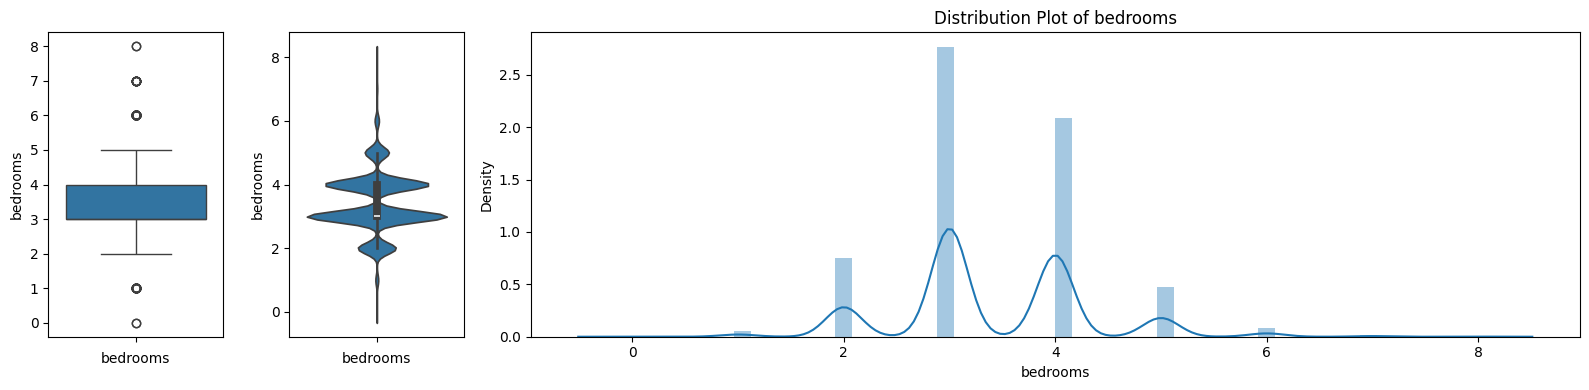

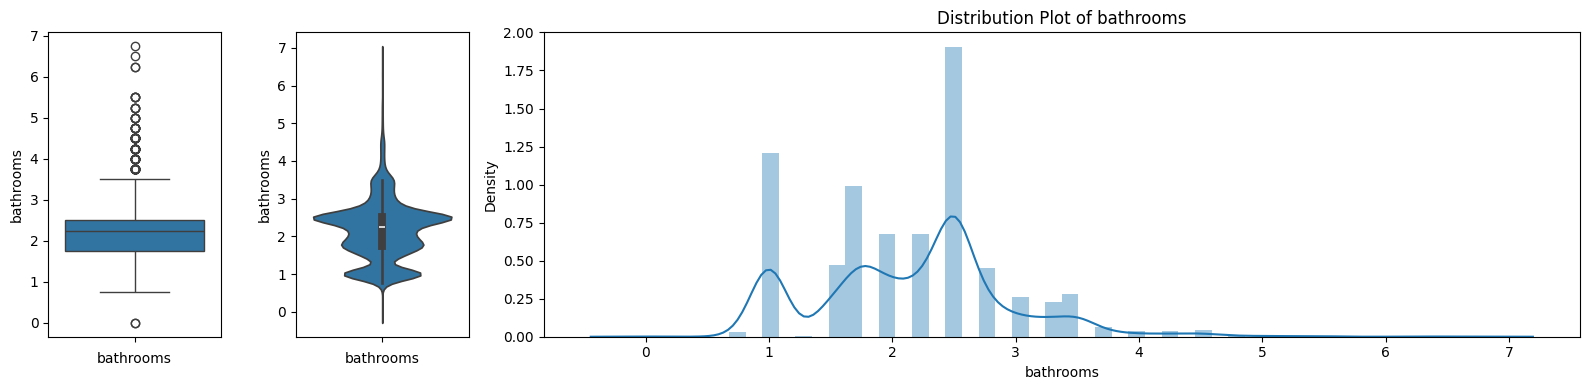

In [21]:
plot_numerical_features(train[numerical_features[1:3]])

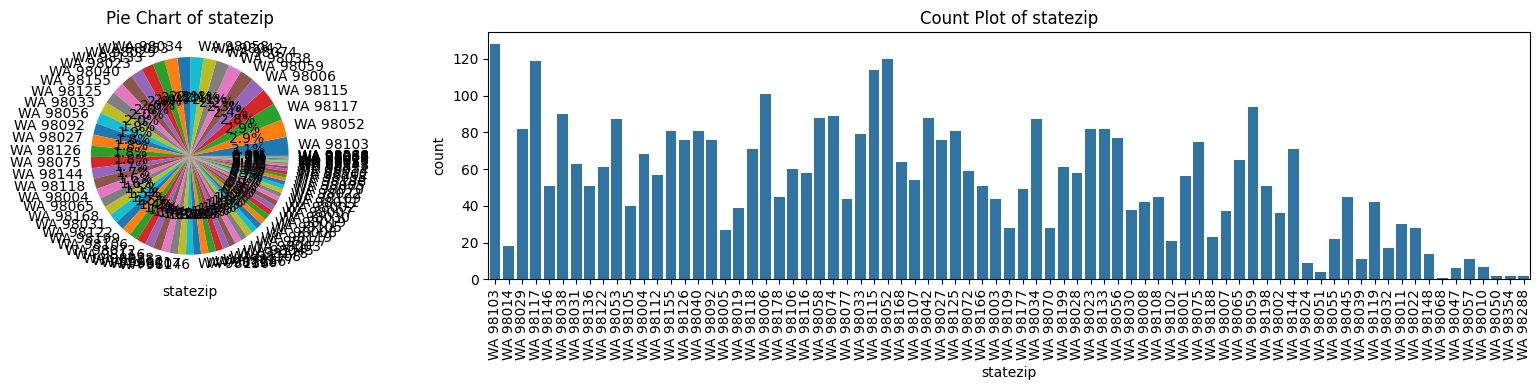

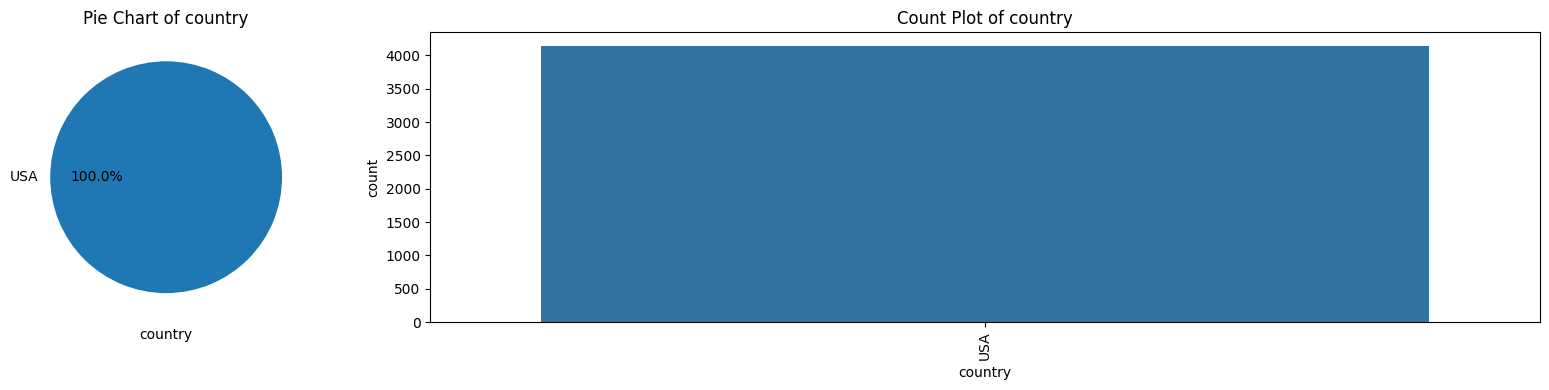

In [22]:
plot_categorical_features(train[categorical_features[3:5]])

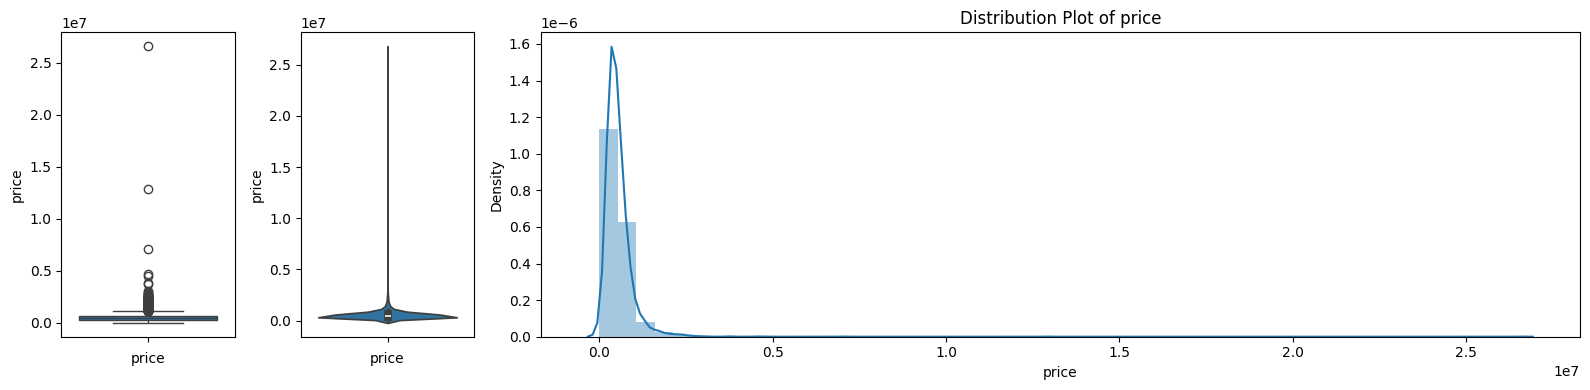

count    4.140000e+03
mean     5.530629e+05
std      5.836865e+05
min      0.000000e+00
25%      3.200000e+05
50%      4.600000e+05
75%      6.591250e+05
max      2.659000e+07
Name: price, dtype: float64

In [23]:
target_feature = "price"
plot_numerical_features(train[[target_feature]])
train['price'].describe()


Remove top 1% outliers
clean the plots instantly.

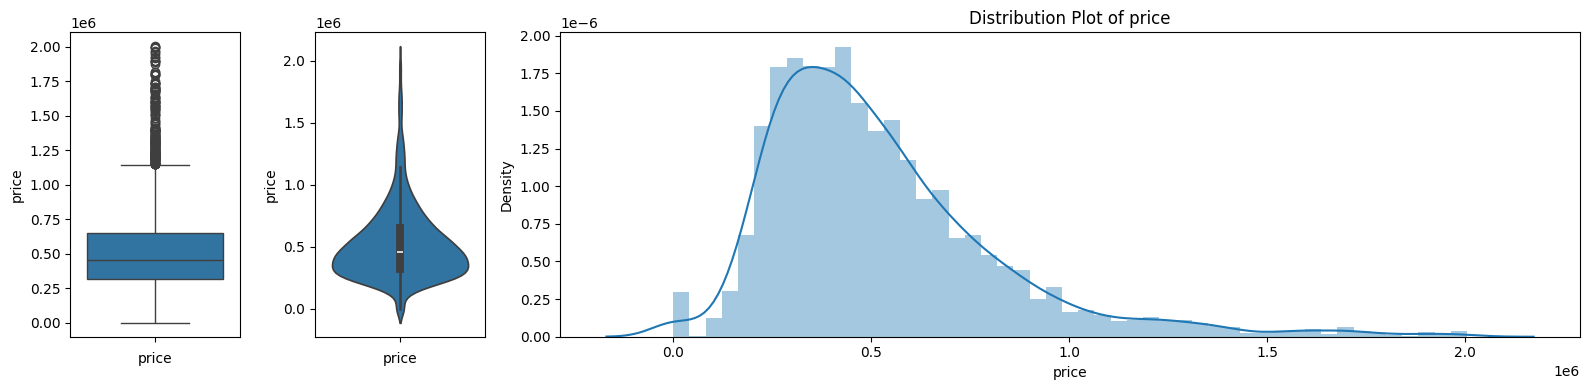

In [24]:
q99 = train['price'].quantile(0.99)
clean_df = train[train['price'] <= q99]

plot_numerical_features(clean_df[['price']])


Log transform price
for distribution normal and perfect for ML.

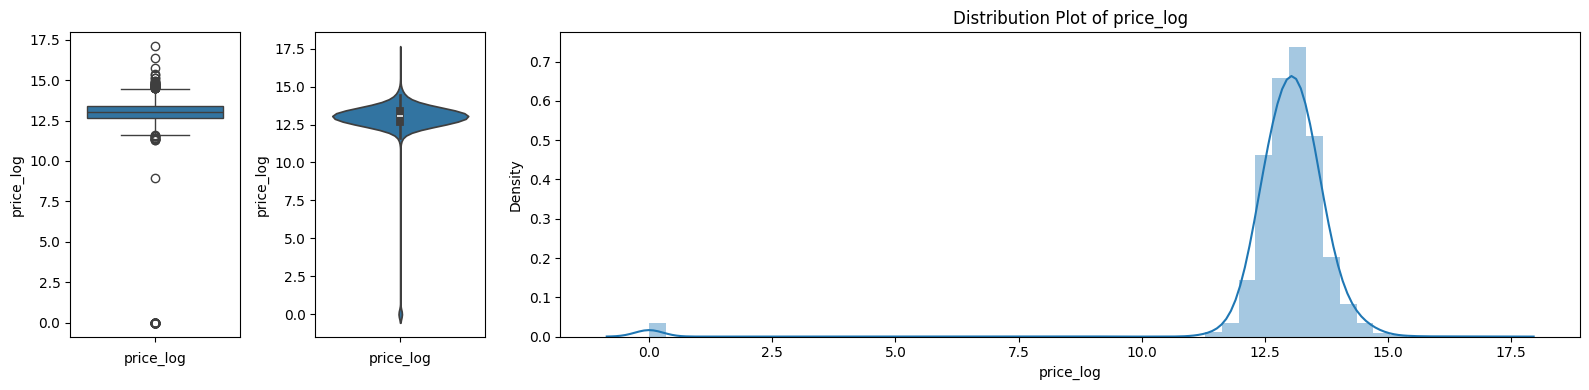

In [25]:


train['price_log'] = np.log1p(train['price'])
plot_numerical_features(train[['price_log']])


Clip extreme values

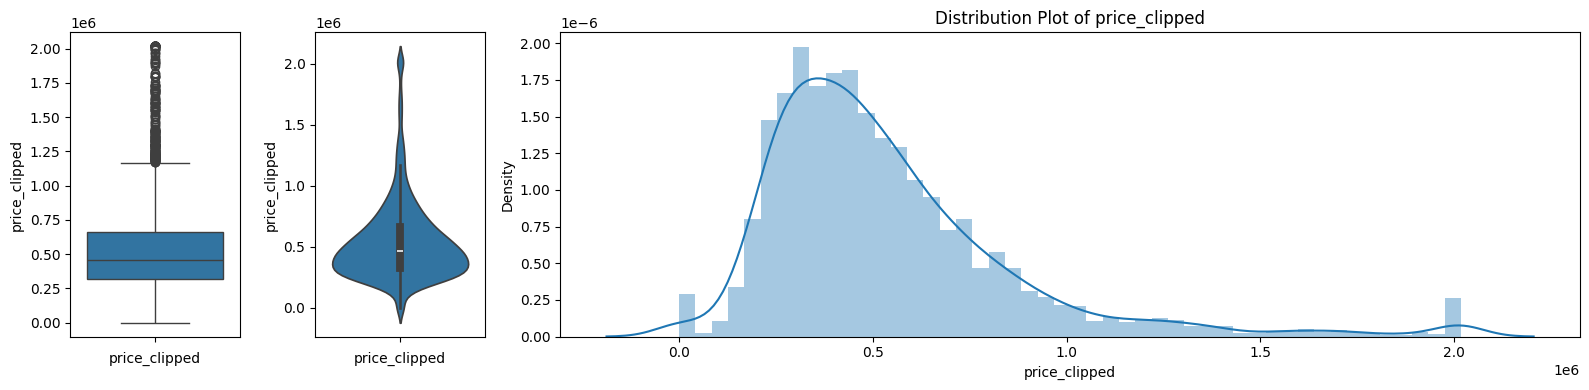

In [26]:
train['price_clipped'] = train['price'].clip(upper=train['price'].quantile(0.99))
plot_numerical_features(train[['price_clipped']])


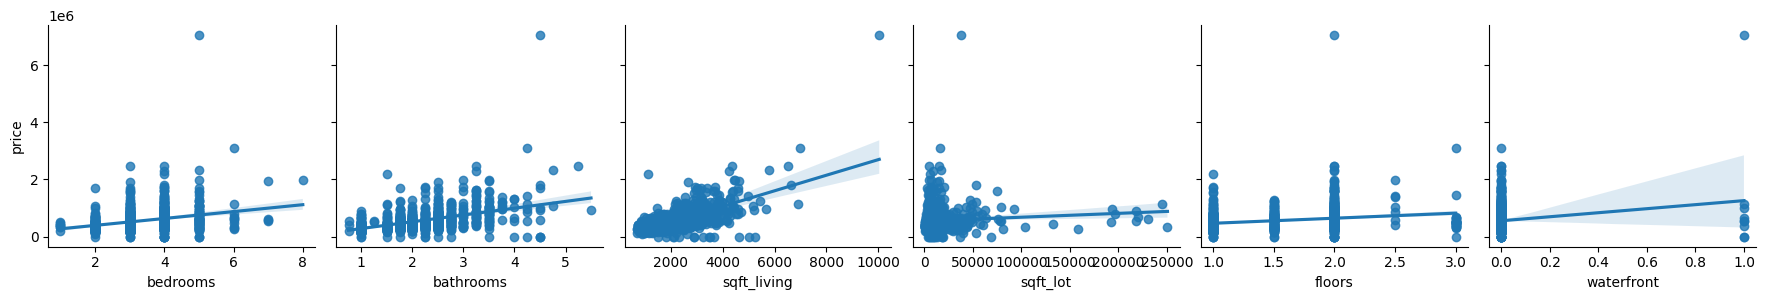

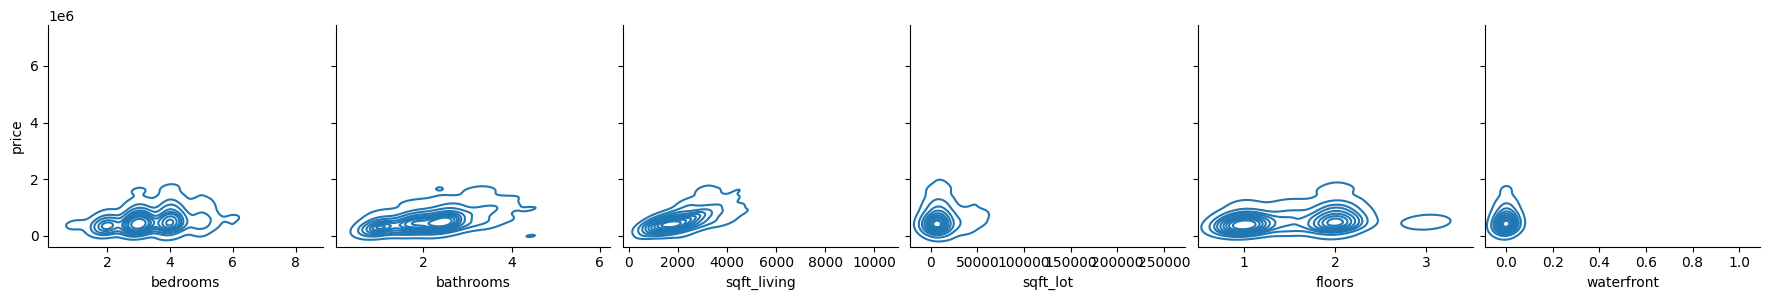

In [27]:
plot_features_correlation(train, numerical_features[1:7], target_feature, plot_kinds=['reg', 'kde'])

In [28]:
show_dtypes(train)

,dtype,# columns,columns
0,int64,9,"['sqft_living', 'sqft_lot', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']"
1,float64,6,"['price', 'bedrooms', 'bathrooms', 'floors', 'price_log', 'price_clipped']"
2,object,5,"['date', 'street', 'city', 'statezip', 'country']"


In [29]:
from sklearn.preprocessing import LabelEncoder

def encode_str_features(df):
    df = df.copy()
    categorical_features = get_categorical_features(df)
    label_encoder = LabelEncoder()
    for col in categorical_features:
        df[col] = label_encoder.fit_transform(df[col])
    
    return df

In [30]:
train = encode_str_features(train)
train.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country,price_log,price_clipped
0,5,376000.0,3.0,2.00,1340,1384,3.0,0,0,3,1340,0,2008,0,3962,34,47,0,12.837347,376000.0
1,5,800000.0,4.0,3.25,3540,159430,2.0,0,0,3,3540,0,2007,0,2491,7,10,0,13.592368,800000.0
2,5,2238888.0,5.0,6.50,7270,130017,2.0,0,0,3,6420,850,2010,0,3511,15,17,0,14.621490,2018420.0
3,5,324000.0,3.0,2.25,998,904,2.0,0,0,3,798,200,2007,0,3762,34,56,0,12.688502,324000.0
4,6,549900.0,5.0,2.75,3060,7015,1.0,0,0,5,1600,1460,1979,0,177,34,65,0,13.217494,549900.0


In [31]:
show_dtypes(train)

,dtype,# columns,columns
0,int64,14,"['date', 'sqft_living', 'sqft_lot', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'street', 'city', 'statezip', 'country']"
1,float64,6,"['price', 'bedrooms', 'bathrooms', 'floors', 'price_log', 'price_clipped']"


<a id="step-1.3"></a>
## Step 1.3: Feature engineering
This step will construct new features based on existing ones. The importance of feature engineering lies in its ability to enhance the predictive power of machine learning models by creating informative, relevant, and discriminative features.

In [32]:
def add_columns(df):
    df = df.copy()
    df["SqFtPerRoom"]        = df["GrLivArea"] / (df["TotRmsAbvGrd"] + df["FullBath"] + df["HalfBath"] + df["KitchenAbvGr"])
    df['Total_Home_Quality'] = df['OverallQual'] + df['OverallCond']
    df['Total_Bathrooms']    = df['FullBath'] + 0.5 * df['HalfBath'] + df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
    df["HighQualSF"]         = df["1stFlrSF"] + df["2ndFlrSF"]
    df['TotalSF']            = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['Age']                = df['YrSold'] - df['YearBuilt']
    
    return df

In [33]:
show_dtypes(train)

,dtype,# columns,columns
0,int64,14,"['date', 'sqft_living', 'sqft_lot', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'street', 'city', 'statezip', 'country']"
1,float64,6,"['price', 'bedrooms', 'bathrooms', 'floors', 'price_log', 'price_clipped']"


<a id="step-1.4"></a>
## Step 1.4: Process feature skew
Processing feature skew involves addressing the asymmetry or lack of symmetry in the distribution of feature values within a dataset. Skewed features can adversely affect the performance of machine learning models, particularly those sensitive to the distribution of data, such as linear regression. To mitigate skewness, various techniques can be employed, including logarithmic or square root transformations to reduce the influence of outliers and make the distribution more symmetrical. 

In [34]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()

def get_skewed_features(df, skewed_threshold=0.75):
    df = df.copy()
    numerical_features = get_numerical_features(df)
    skewed = df[numerical_features].apply(lambda x: x.skew())
    skewed = skewed.sort_values(ascending=False)
    skewed = skewed.reset_index()
    skewed.columns = ['Feature', 'Skew']
    skewed_features = list(skewed[abs(skewed['Skew']) > skewed_threshold]['Feature'])
    non_skewed_features = list(set(numerical_features)-set(skewed_features))
    return skewed_features, non_skewed_features


def transform_skewed_features(df, skewed_features):
    df = df.copy()
    for col in skewed_features:
        df[col] = np.log1p(df[col])
    
    return df

def transform_non_skewed_features(df, non_skewed_features):
    df = df.copy()
    for col in non_skewed_features:
        df[col] = standardScaler.fit_transform(df[[col]])
    return df

The following script performs feature preprocessing on the dataset, starting with the identification of skewed numerical features using a specified threshold. Features with skewness above this threshold are labeled as "skewed," while others are labeled "non-skewed." Skewed features undergo a logarithmic transformation to reduce skewness, while non-skewed features are standardized using the StandardScaler from sklearn.preprocessing. Visualization functions are then employed to plot the correlations between selected features and a target feature before and after transformation, allowing for the observation of the impact of the transformations on feature distributions and their relationship with the target. The transformations ensure that the dataset is prepared for use in machine learning models, mitigating the adverse effects of skewed distributions and ensuring standardized scales for non-skewed features.

In [35]:
skewed_features, non_skewed_features = get_skewed_features(train)
print(f"Skewed Features: ({len(skewed_features)})")
print("  " + ", ".join(skewed_features))
print("\n" + "-"*40 + "\n")
print(f"Non-Skewed Features: ({len(non_skewed_features)})")
print("  " + ", ".join(non_skewed_features))

Skewed Features: (10)
  price, sqft_lot, waterfront, view, price_clipped, sqft_basement, sqft_living, sqft_above, condition, price_log

----------------------------------------

Non-Skewed Features: (10)
  yr_built, floors, yr_renovated, city, bathrooms, date, country, statezip, street, bedrooms


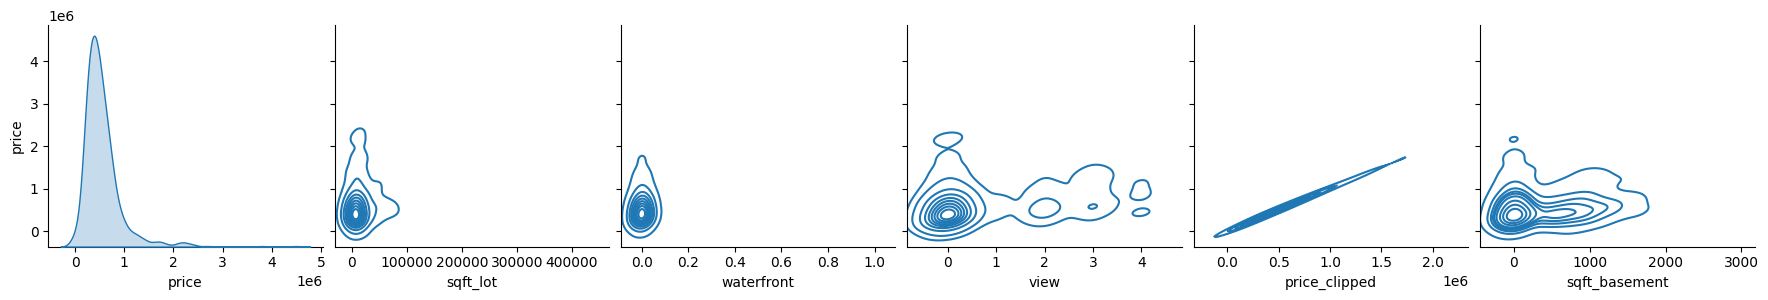

In [36]:
target_feature = 'price'
plot_features_correlation(train, skewed_features[:6], target_feature, plot_kinds=['kde'])


In [37]:
train = transform_skewed_features(train, skewed_features)

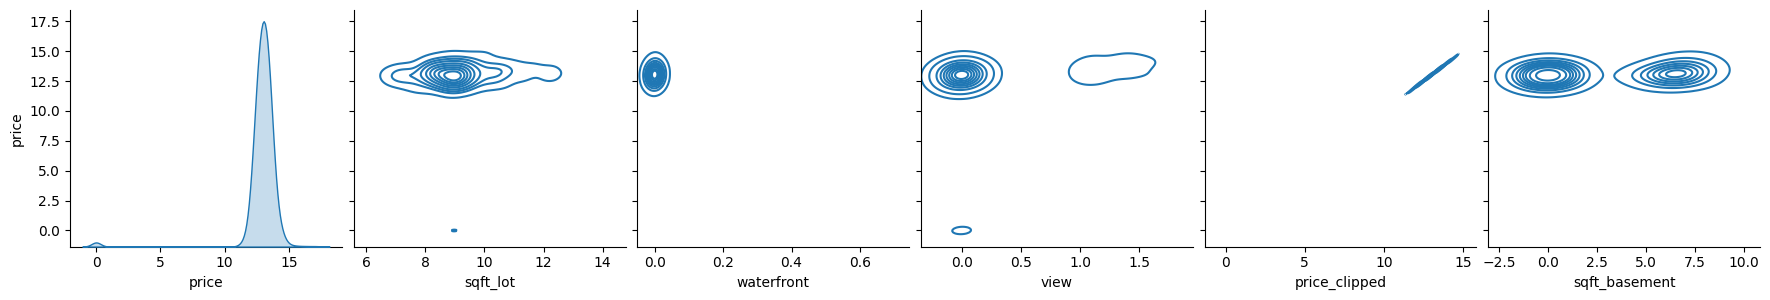

In [38]:
plot_features_correlation(train, skewed_features[:6], target_feature, plot_kinds=['kde'])

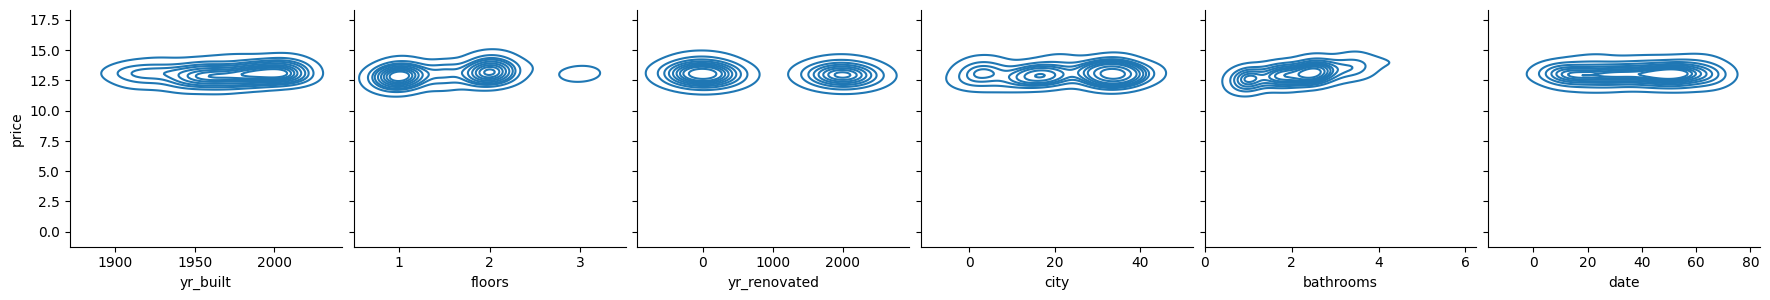

In [39]:
plot_features_correlation(train, non_skewed_features[:6], target_feature, plot_kinds=['kde'])

In [40]:
train = transform_non_skewed_features(train, non_skewed_features)

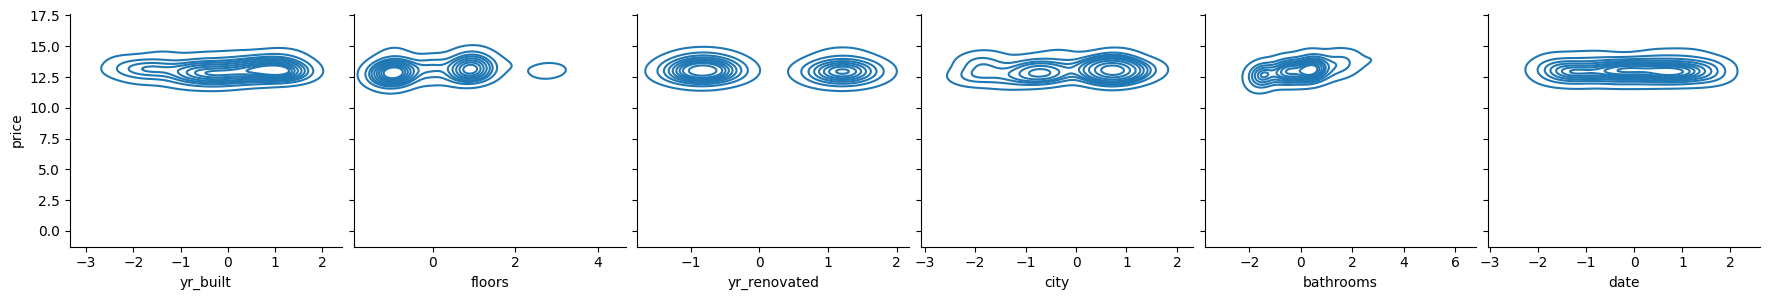

In [41]:
plot_features_correlation(train, non_skewed_features[:6], target_feature, plot_kinds=['kde'])

<a id="step-1.5"></a>
## Step 1.5: Outlier detection and feature selection processing
The following code performs multiple process for analyzing feature-target relationships and detecting outliers within numerical features of the dataset. Initially, it computes the correlations between numerical features and the SalePrice (target variable), presenting the results through a bar plot visualization. Additionally, it generates a heatmap to illustrate the correlation matrix of numerical features. Further functionality includes feature selection based on mutual information with the target variable, visualizing feature importance contributions using bar plots, and plotting individual features against the target while highlighting outliers detected through various outlier detection methods. These methods include Interquartile Range (IQR) and z-score methods.

In [42]:
from matplotlib.colors import LinearSegmentedColormap
from sklearn.feature_selection import mutual_info_regression

def get_target_correlations(df, target_feature):
    numerical_features  = get_numerical_features(df)
    correlation_matrix  = df[numerical_features].corr()
    target_correlations = correlation_matrix[target_feature].sort_values(ascending=False)
    target_correlations = target_correlations.reset_index()
    target_correlations.columns = ['Feature', 'Correlation_with_Target']
    return target_correlations

def plot_target_correlations(target_correlations):
    size=(12, target_correlations.shape[0]//12*4+2)
    plt.figure(figsize=size)
    sns.barplot(y='Feature', x='Correlation_with_Target', data=target_correlations, palette='coolwarm')
    plt.xlabel('Correlation with Target')
    plt.ylabel('Feature')
    plt.title('Correlation of Numerical Features with Target')
    plt.show()

def plot_heatmap2(df, size_factor=1/2):
    df = df[get_numerical_features(df)]
    height = int(len(df.columns) * size_factor)
    font_size = max(min(12, 119 // height), 8)
    cmap = LinearSegmentedColormap.from_list(
        'custom_diverging',
        ['blue', 'lightblue', 'white', 'lightcoral', 'red'],
        N=5
    )
    cbar_kws = {'ticks': [-1, -.5, 0, .5, 1]}
    plot_heatmap(df, size=(height+1, height+1), cmap=cmap, cbar_kws=cbar_kws, font_size=font_size)
    

def feature_selection(X, y, mutual_info_method, importance_threshold=0.1):
    mutual_info = mutual_info_method(X, y)
    features_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': mutual_info
    })
    features_importance = features_importance.sort_values(by='Importance', ascending=False)
    features_importance = features_importance[features_importance['Importance'] > importance_threshold]
    return features_importance

def plot_features_importance(features_importance, size=(12, 8)):
    size=(12, features_importance.shape[0]//12*4+2)
    plt.figure(figsize=size)
    sns.barplot(x='Importance', y='Feature', data=features_importance, palette='viridis')
    plt.xlabel('Importance Contribution (%)')
    plt.title('Importance Contribution of Selected Features')
    plt.show()
    

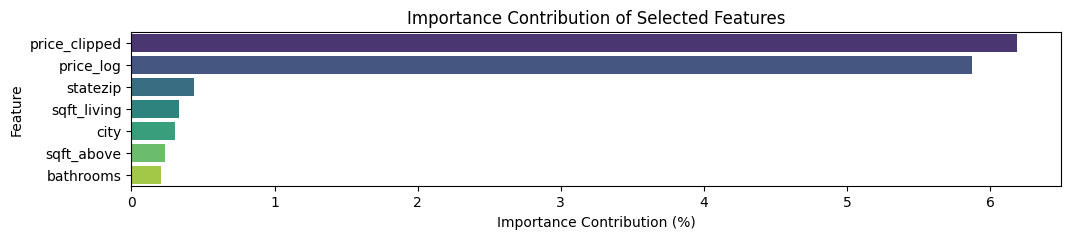

Selected features:
7
18    price_clipped
17        price_log
15         statezip
3       sqft_living
14             city
9        sqft_above
2         bathrooms
Name: Feature, dtype: object


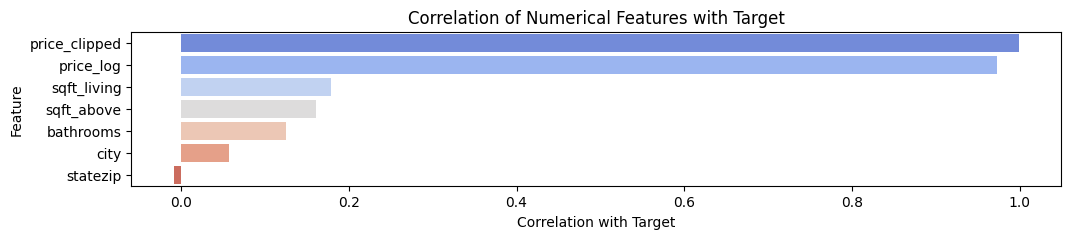

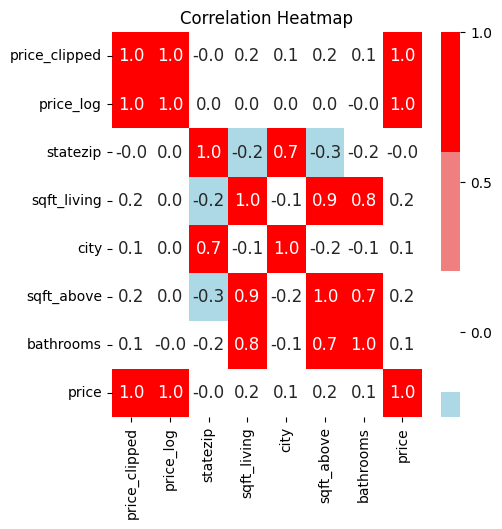

Dataset shape before droping outliers (4140, 8)
Dataset shape after droping outliers  (4028, 8)


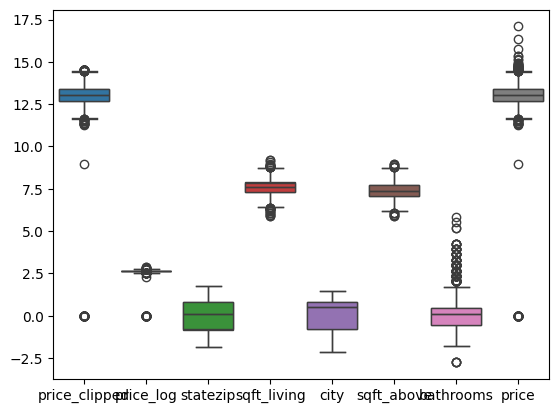

In [43]:
target_correlations = get_target_correlations(train, target_feature)
X, y = split_data_X_y(train, target_feature)
features_importance = feature_selection(X, y, mutual_info_regression)
plot_features_importance(features_importance)
selected_features = features_importance['Feature']
print("Selected features:")
print(len(selected_features))
print(selected_features)
X_selected  = X[selected_features]
plot_target_correlations(target_correlations[target_correlations['Feature'].isin(selected_features)])
plot_heatmap2(pd.concat([X_selected, y], axis=1))

# construct train again from selected_features and target_feature
train = pd.concat([X_selected, y], axis=1)

sns.boxplot(data=train)

print('Dataset shape before droping outliers', train.shape)
# Calculate quartiles
Q1 = train[target_feature].quantile(0.25)
Q3 = train[target_feature].quantile(0.75)

# Calculate IQR (Interquartile Range)
IQR = Q3 - Q1

# Filter outliers
train = train[~((train[target_feature] < (Q1 - 1.5 * IQR)) | (train[target_feature] > (Q3 + 1.5 * IQR)))]
sns.boxplot(data=train)
print('Dataset shape after droping outliers ', train.shape)

In [44]:
train.dtypes


price_clipped    float64
price_log        float64
statezip         float64
sqft_living      float64
city             float64
sqft_above       float64
bathrooms        float64
price            float64
dtype: object

In [45]:
# Check if date column exists
if 'date' in train.columns:
    train['date'] = pd.to_datetime(train['date'])
    train['year'] = train['date'].dt.year
    train['month'] = train['date'].dt.month
    train['day'] = train['date'].dt.day
else:
    print("⚠️ 'date' column not found. Please check train.columns")


⚠️ 'date' column not found. Please check train.columns


In [46]:
from sklearn.preprocessing import LabelEncoder

for col in ['city', 'statezip']:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])


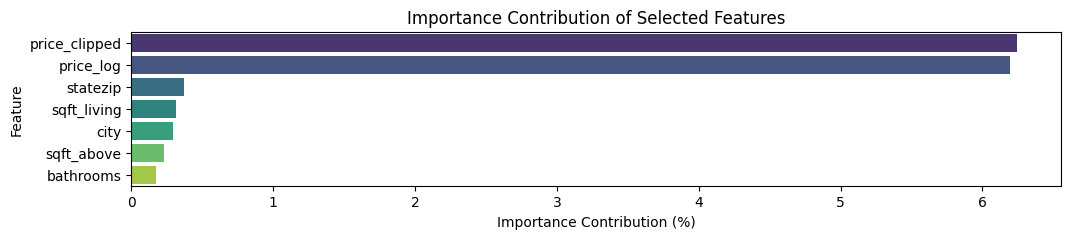

Selected features:
7
0    price_clipped
1        price_log
2         statezip
3      sqft_living
4             city
5       sqft_above
6        bathrooms
Name: Feature, dtype: object


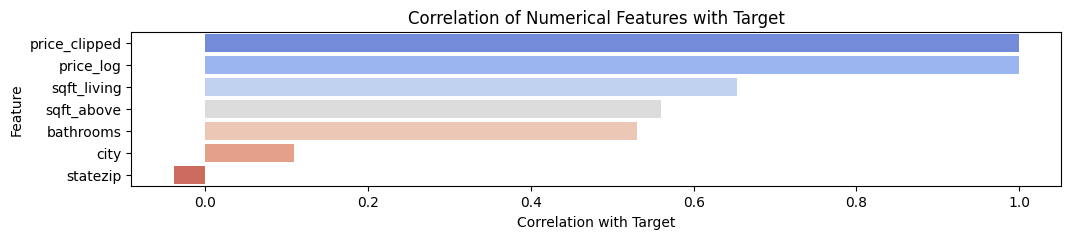

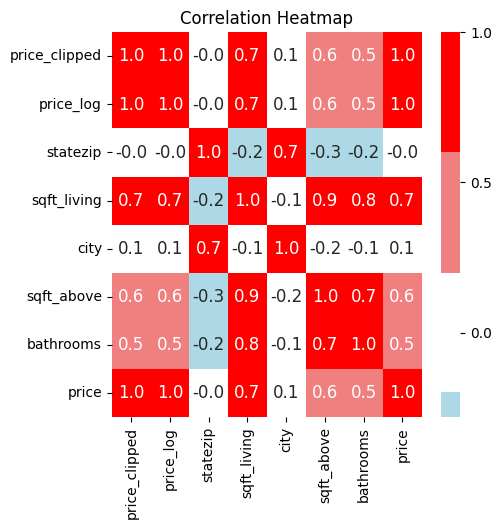

Dataset shape before droping outliers (4028, 8)
Dataset shape after droping outliers  (4017, 8)


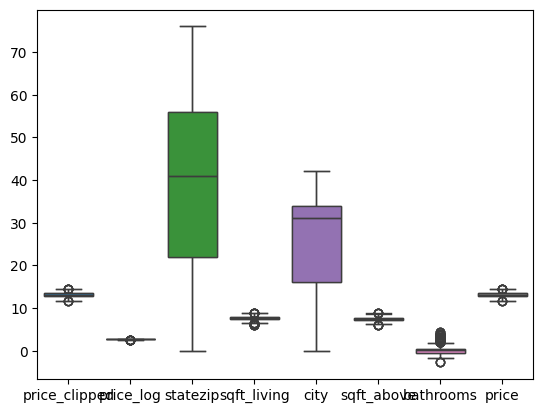

In [47]:
target_correlations = get_target_correlations(train, target_feature)
X, y = split_data_X_y(train, target_feature)
features_importance = feature_selection(X, y, mutual_info_regression)
plot_features_importance(features_importance)
selected_features = features_importance['Feature']
print("Selected features:")
print(len(selected_features))
print(selected_features)
X_selected  = X[selected_features]
plot_target_correlations(target_correlations[target_correlations['Feature'].isin(selected_features)])
plot_heatmap2(pd.concat([X_selected, y], axis=1))

# construct train again from selected_features and target_feature
train = pd.concat([X_selected, y], axis=1)

sns.boxplot(data=train)

print('Dataset shape before droping outliers', train.shape)
# Calculate quartiles
Q1 = train[target_feature].quantile(0.25)
Q3 = train[target_feature].quantile(0.75)

# Calculate IQR (Interquartile Range)
IQR = Q3 - Q1

# Filter outliers
train = train[~((train[target_feature] < (Q1 - 1.5 * IQR)) | (train[target_feature] > (Q3 + 1.5 * IQR)))]
sns.boxplot(data=train)
print('Dataset shape after droping outliers ', train.shape)

<a id="step-2"></a>
# <div style="background-color: #CE5A67; color:white; font-family:Arial; text-align:center; border-radius:15px;">Step 2: Linear Regression Evaluation</div>
<p>This step focuses on exploring Linear Regression models by testing various learning rates and applying regularization techniques such as Lasso and Ridge. We will evaluate the models' performance, plot the results, and ultimately select the best model based on the Root Mean Square Error (RMSE).</p>

In [48]:
# Linear Regression model implementation to be able to customize learning rate
class MultipleLinearRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000, epsilon=None):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.epsilon = epsilon
        self.weights = None
        self.bias = None
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        prev_loss = float('inf')  # Set initial loss to infinity
        
        for i in range(self.n_iterations):
            # Compute predictions
            y_predicted = np.dot(X, self.weights) + self.bias
            
            # Compute gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)
            
            # Update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            # print('----------------------------')
            # print(i)
            # print(y_predicted)
            # print(self.weights)
            # print(self.bias)
            # print('----------------------------')
            # Compute current loss
            current_loss = np.mean((y - y_predicted) ** 2)
            
            # Check for convergence
            if self.epsilon and abs(prev_loss - current_loss) < self.epsilon:
                break
                
            prev_loss = current_loss
            
        return i+1
    
    def predict(self, X):
        # print(X)
        # print(self.weights)
        # print(self.bias)
        return np.dot(X, self.weights) + self.bias

In [49]:
def plot_actual_vs_predicted(y, y_pred):
    plt.figure(figsize=(12, 7))
    
    # Actual values
    plt.scatter(range(len(y)), y, label="Actual", alpha=0.6)
    
    # Predicted values
    plt.scatter(range(len(y_pred)), y_pred, label="Predicted", alpha=0.6)
    
    plt.title("Actual vs Predicted House Prices")
    plt.xlabel("Sample Index")
    plt.ylabel("Price")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [50]:
generate_summary_table(train)

,column,dtype,count,mean,std,min,25%,50%,75%,max,nunique,unique,mode,mode #,mode %,null #,null %
2,statezip,int64,4017,39.0,20.8,0.0,22.0,41.0,56.0,76.0,77,"[47, 10, 56, 65, 23, 19, 63, 59, 32, 48, 17, 3, 53, 67, 61, 25, 45, 4, 11, 57, 5, 71, 49, 55, 36, 42, 44, 21, 54, 31, 69, 50, 26, 15, 60, 41, 68, 2, 52, 70, 22, 40, 74, 16, 13, 62, 34, 18, 7, 51, 46, 0, 43, 72, 6, 38, 37, 73, 1, 64, 14, 30, 33, 27, 58, 20, 9, 12, 66, 24, 39, 28, 35, 8, 29, 76, 75]",47.000000,128,3.2,0,0.0
4,city,int64,4017,25.0,11.6,0.0,16.0,31.0,34.0,42.0,43,"[34, 7, 20, 17, 30, 15, 8, 35, 22, 1, 3, 11, 31, 32, 41, 18, 6, 14, 25, 40, 16, 33, 24, 9, 19, 37, 10, 13, 29, 39, 26, 5, 12, 21, 38, 27, 4, 2, 0, 28, 23, 42, 36]",34.000000,1384,34.5,0,0.0
0,price_clipped,float64,4017,13.0,0.5,11.7,12.7,13.0,13.4,14.4,1561,,12.611541,39,1.0,0,0.0
1,price_log,float64,4017,2.6,0.0,2.5,2.6,2.6,2.7,2.7,1561,,2.610918,39,1.0,0,0.0
3,sqft_living,float64,4017,7.6,0.4,5.9,7.3,7.6,7.9,8.9,516,,7.450661,31,0.8,0,0.0
5,sqft_above,float64,4017,7.4,0.4,5.9,7.1,7.4,7.7,8.9,469,,7.090910,42,1.0,0,0.0
6,bathrooms,float64,4017,-0.0,1.0,-2.8,-0.5,0.1,0.4,4.3,21,"[-0.20779445947461847, 1.385296396497456, 0.11082371171979641, 0.7480600541086262, 0.4294418829142113, -1.4822671442522781, 2.9783872524695303, -0.8450308018634483, -0.5264126306690333, 1.7039145676918708, 1.0666782253030411, 2.022532738886286, 3.2970054236639452, 2.3411509100807004, -1.8008853154466928, 2.6597690812751154, 3.61562359485836, 3.934241766052775, -1.1636489730578632, -2.7567398290299376, 4.25285993724719]",0.429442,1055,26.3,0,0.0
7,price,float64,4017,13.0,0.5,11.7,12.7,13.0,13.4,14.4,1561,,12.611541,39,1.0,0,0.0


alpha 0.01 start..
alpha 0.01 end..
alpha 0.1 start..
alpha 0.1 end..
alpha 1 start..
alpha 1 end..
alpha 10 start..
alpha 10 end..
alpha 100 start..
alpha 100 end..

MSE values for different alphas: [7.825814154282078e-30, 7.825814154282078e-30, 7.825814154282078e-30, 7.825814154282078e-30, 7.825814154282078e-30]


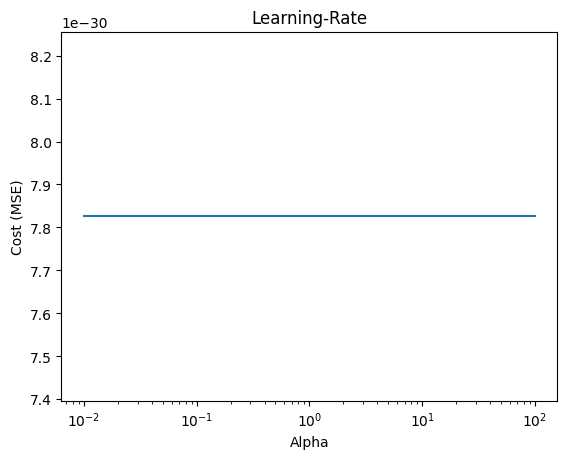

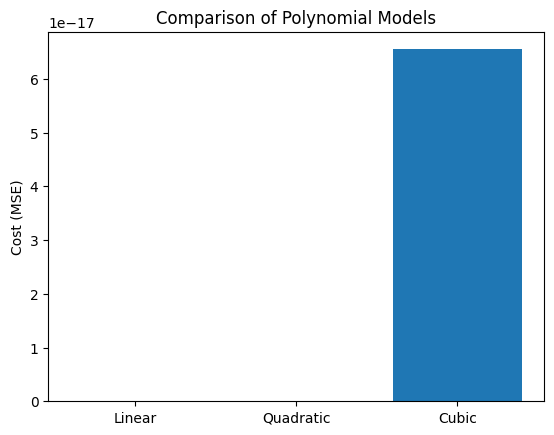

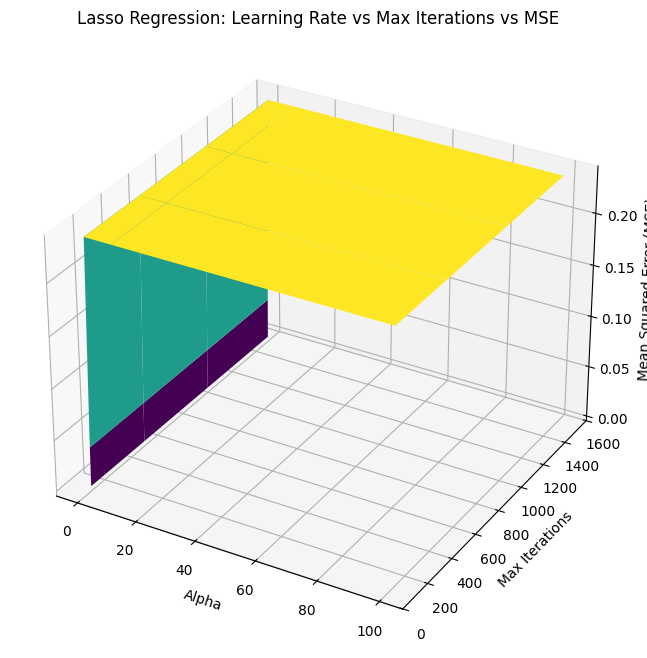

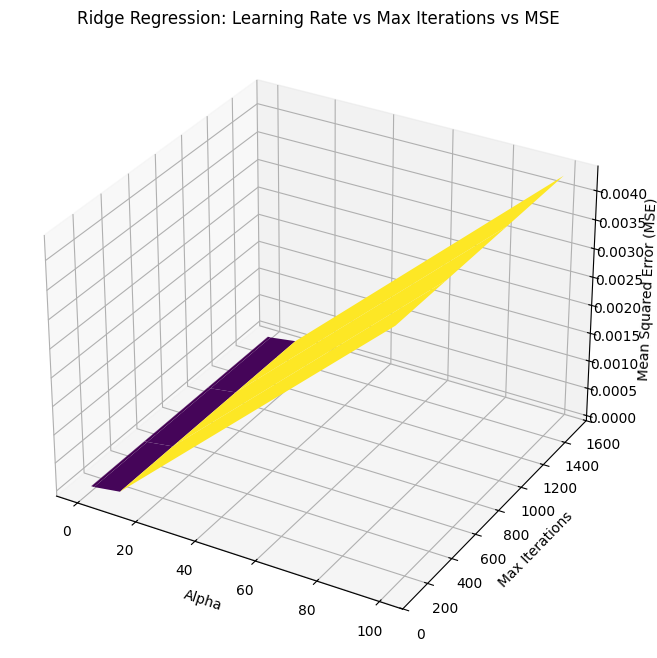

Best combination for Lasso:
Alpha: 0.01
Max Iterations: 100
Minimum Mean Squared Error (MSE): 0.00038834929361225513

Best combination for Ridge:
Alpha: 0.01
Max Iterations: 100
Minimum Mean Squared Error (MSE): 1.997123742270949e-09
The best model is Ridge with Alpha=0.01 and Max Iterations=100.
The minimum Mean Squared Error (MSE) for the best model is: 1.997123742270949e-09


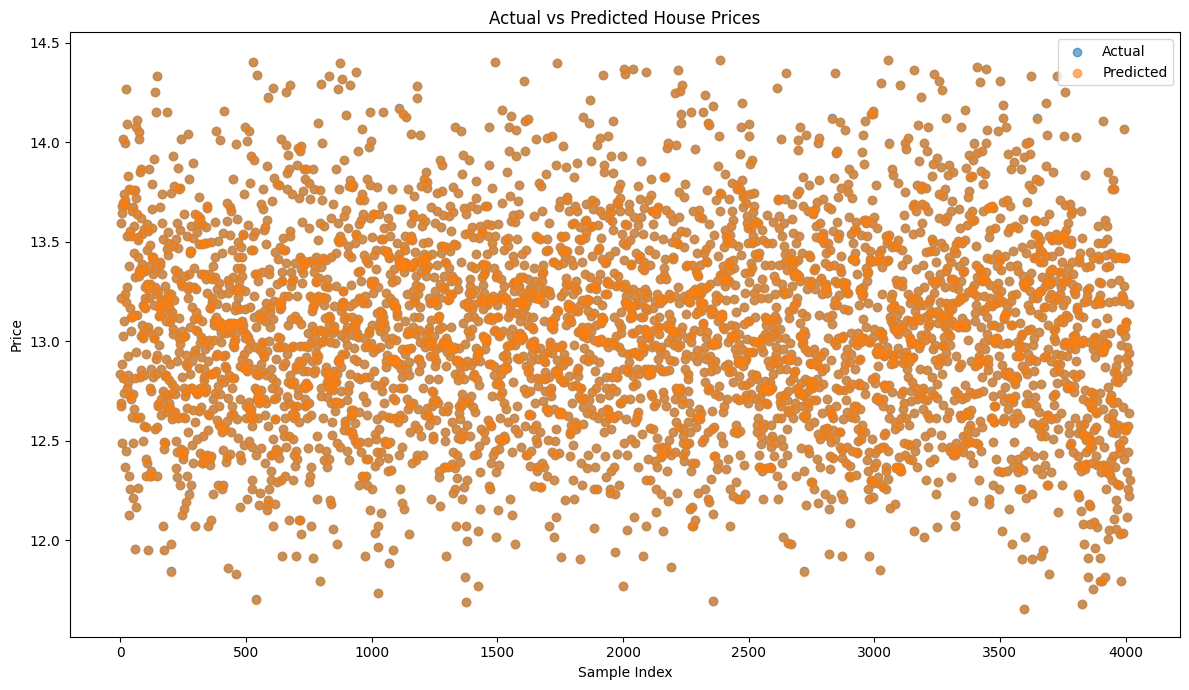

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Define alphas
alphas = [0.01, 0.1, 1, 10, 100]

# Split the data
X_train, X_test, y_train, y_test = split_data_train_test(train, target_feature)

errors = []

for alpha in alphas:
    print(f'alpha {alpha} start..')
    
    model = LinearRegression()  # using LinearRegression instead of Ridge
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    errors.append(mean_squared_error(y_test, y_pred))
    
    print(f'alpha {alpha} end..')

print("\nMSE values for different alphas:", errors)

plt.figure()
plt.plot(alphas, errors)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Cost (MSE)')
plt.title('Learning-Rate')
plt.show()


# Investigate Polynomial Functions
X, y = split_data_X_y(train, target_feature)
# Linear
poly_1 = PolynomialFeatures(degree=1)
X_poly_1 = poly_1.fit_transform(X)

# Quadratic
poly_2 = PolynomialFeatures(degree=2)
X_poly_2 = poly_2.fit_transform(X)

# Cubic
poly_3 = PolynomialFeatures(degree=3)
X_poly_3 = poly_3.fit_transform(X)

# Train and evaluate each model
models = [LinearRegression(), LinearRegression(), LinearRegression()]
polys = [X_poly_1, X_poly_2, X_poly_3]

errors = []

for model, poly_X in zip(models, polys):
    X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(poly_X, y, test_size=0.2, random_state=42)
    model.fit(X_train_poly, y_train_poly)
    y_pred_poly = model.predict(X_test_poly)
    errors.append(mean_squared_error(y_test_poly, y_pred_poly))

plt.figure()
plt.bar(['Linear', 'Quadratic', 'Cubic'], errors)
plt.ylabel('Cost (MSE)')
plt.title('Comparison of Polynomial Models')
plt.show()

# Define a list of alpha values representing different iterations
alphas = [0.01, 0.1, 1, 10, 100]
max_iters = [100, 500, 1000, 1500]  # Different values of max_iter to test

# Create a meshgrid of alpha and max_iter values
alpha_mesh, max_iter_mesh = np.meshgrid(alphas, max_iters)

# Initialize arrays to store errors for Lasso and Ridge
lasso_errors = np.zeros_like(alpha_mesh)
ridge_errors = np.zeros_like(alpha_mesh)

# Iterate over each combination of alpha and max_iter
for i in range(len(alphas)):
    for j in range(len(max_iters)):
        # Lasso
        lasso = Lasso(alpha=alphas[i], max_iter=max_iters[j])
        lasso.fit(X_train, y_train)
        y_pred_lasso = lasso.predict(X_test)
        lasso_errors[j, i] = mean_squared_error(y_test, y_pred_lasso)
        
        # Ridge
        ridge = Ridge(alpha=alphas[i], max_iter=max_iters[j])
        ridge.fit(X_train, y_train)
        y_pred_ridge = ridge.predict(X_test)
        ridge_errors[j, i] = mean_squared_error(y_test, y_pred_ridge)

# Plot 3D surface for Lasso
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(alpha_mesh, max_iter_mesh, lasso_errors, cmap='viridis')
ax.set_xlabel('Alpha')
ax.set_ylabel('Max Iterations')
ax.set_zlabel('Mean Squared Error (MSE)')
ax.set_title('Lasso Regression: Learning Rate vs Max Iterations vs MSE')
plt.show()

# Plot 3D surface for Ridge
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(alpha_mesh, max_iter_mesh, ridge_errors, cmap='viridis')
ax.set_xlabel('Alpha')
ax.set_ylabel('Max Iterations')
ax.set_zlabel('Mean Squared Error (MSE)')
ax.set_title('Ridge Regression: Learning Rate vs Max Iterations vs MSE')
plt.show()

# Find the best combination for Lasso
min_mse_lasso = np.min(lasso_errors)
min_mse_index_lasso = np.unravel_index(np.argmin(lasso_errors), lasso_errors.shape)
best_alpha_lasso = alphas[min_mse_index_lasso[1]]
best_max_iter_lasso = max_iters[min_mse_index_lasso[0]]

# Find the best combination for Ridge
min_mse_ridge = np.min(ridge_errors)
min_mse_index_ridge = np.unravel_index(np.argmin(ridge_errors), ridge_errors.shape)
best_alpha_ridge = alphas[min_mse_index_ridge[1]]
best_max_iter_ridge = max_iters[min_mse_index_ridge[0]]

print("Best combination for Lasso:")
print("Alpha:", best_alpha_lasso)
print("Max Iterations:", best_max_iter_lasso)
print("Minimum Mean Squared Error (MSE):", min_mse_lasso)

print("\nBest combination for Ridge:")
print("Alpha:", best_alpha_ridge)
print("Max Iterations:", best_max_iter_ridge)
print("Minimum Mean Squared Error (MSE):", min_mse_ridge)

# Compare the minimum MSE values for Lasso and Ridge
if min_mse_lasso < min_mse_ridge:
    best_model = "Lasso"
    best_alpha = best_alpha_lasso
    best_max_iter = best_max_iter_lasso
    min_mse = min_mse_lasso
else:
    best_model = "Ridge"
    best_alpha = best_alpha_ridge
    best_max_iter = best_max_iter_ridge
    min_mse = min_mse_ridge

print(f"The best model is {best_model} with Alpha={best_alpha} and Max Iterations={best_max_iter}.")
print(f"The minimum Mean Squared Error (MSE) for the best model is: {min_mse}")

# Train the best model using the entire dataset
if best_model == "Lasso":
    best_model = Lasso(alpha=best_alpha, max_iter=best_max_iter)
elif best_model == "Ridge":
    best_model = Ridge(alpha=best_alpha, max_iter=best_max_iter)

best_model.fit(X_train, y_train)

# Make predictions on the entire dataset
y_pred = best_model.predict(X)

plot_actual_vs_predicted(y, y_pred)


<a id="step-3"></a>
# <div style="background-color: #CE5A67; color:white; font-family:Arial; text-align:center; border-radius:15px;">Step 3: Compartive analysis of different models</div>
<p>This step will explore several models in an attempt to identify better results by comparing RMSE</p>

In [52]:
from sklearn.metrics         import mean_squared_error, mean_absolute_error, max_error, r2_score, explained_variance_score
from sklearn.linear_model    import LinearRegression, Ridge, Lasso
from sklearn.svm             import SVR
from sklearn.tree            import DecisionTreeRegressor
from sklearn.neighbors       import KNeighborsRegressor
from sklearn.ensemble        import RandomForestRegressor
import time


In [53]:
models = {
    'LinearRegression':          LinearRegression(),
    'Ridge':                     Ridge(),
    'Lasso':                     Lasso(),
    'DecisionTreeRegressor':     DecisionTreeRegressor(),
    'KNeighborsRegressor':       KNeighborsRegressor(),
    'RandomForestRegressor':     RandomForestRegressor(),
    'SupportVectorRegressor':    SVR(),
}

def evaluate_model(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    me  = max_error(y_test, y_pred)
    r2  = r2_score(y_test, y_pred)
    ev  = explained_variance_score(y_test, y_pred)

    result = {
        'Mean Absolute Error': mae,
        'Mean Squared Error': mse,
        'Max Error': me,
        'R^2': r2,
        'Explained Variance': ev,
    }
    return result

def run_models(models, X_train, X_test, y_train, y_test):
    results = {}
    for name, model in models.items():
        print(f'Model {name} start..')
        start_time = time.time()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results[name] = evaluate_model(y_test, y_pred)
        end_time = time.time()
        duration = round((end_time - start_time) / 60, 2)
        print(f'Model {name} run in'.ljust(50), f'{duration} minutes')
    results = pd.DataFrame(results).T
    results = results.reset_index()
    return results

def plot_models_results(results, metric):
    plt.figure(figsize=(12, 6))
    sns.barplot(data=results, x='index', y=metric)

    plt.title(f"Model Comparison using {metric}")
    plt.xlabel("Model")
    plt.ylabel(metric)

    yminlim = results[metric].min()
    ymaxlim = results[metric].max()
    yrange = (ymaxlim - yminlim) * .1
    yminlim -= yrange
    ymaxlim += yrange
    plt.ylim(yminlim, ymaxlim)
    plt.xticks(rotation=90)
    
    plt.tight_layout()
    plt.show()
    
def get_best_model(results_df, models, metric):
    best_model_name = results_df.sort_values(by=[metric]).head(1)['index'].iloc[0]
    best_model = models[best_model_name]
    return best_model

Model LinearRegression start..
Model LinearRegression run in                      0.0 minutes
Model Ridge start..
Model Ridge run in                                 0.0 minutes
Model Lasso start..
Model Lasso run in                                 0.0 minutes
Model DecisionTreeRegressor start..
Model DecisionTreeRegressor run in                 0.0 minutes
Model KNeighborsRegressor start..
Model KNeighborsRegressor run in                   0.0 minutes
Model RandomForestRegressor start..
Model RandomForestRegressor run in                 0.03 minutes
Model SupportVectorRegressor start..
Model SupportVectorRegressor run in                0.01 minutes


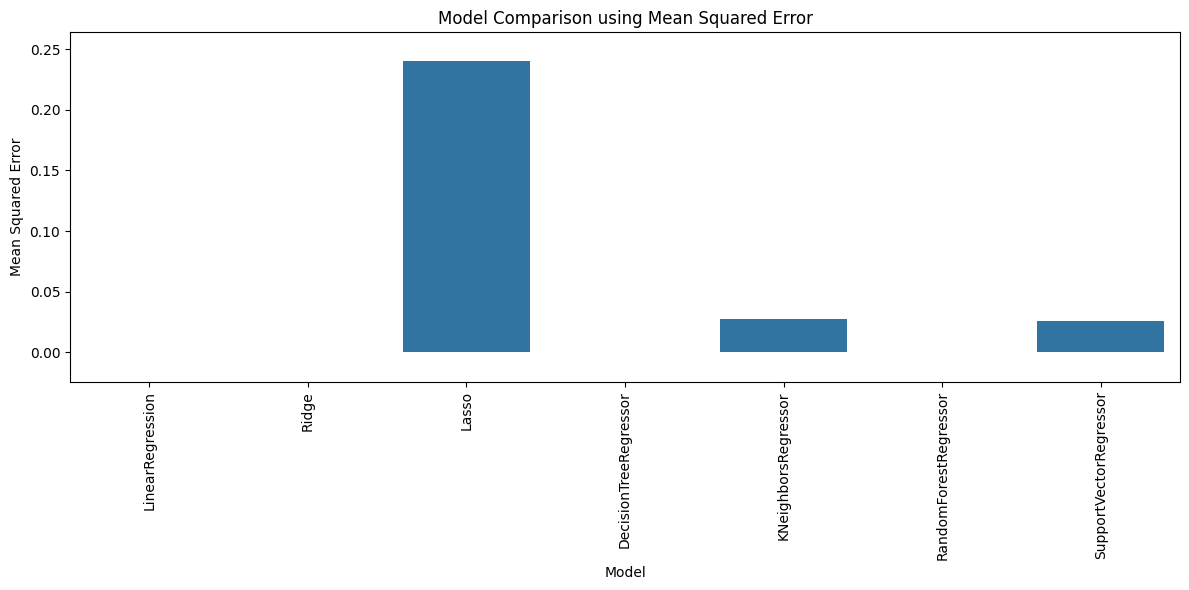

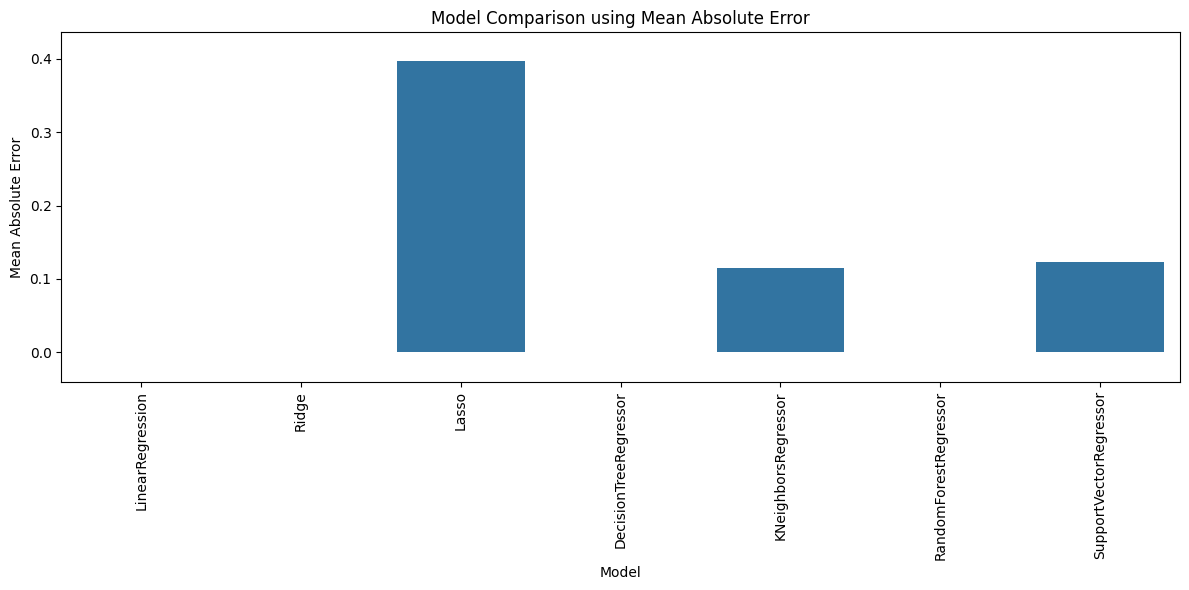

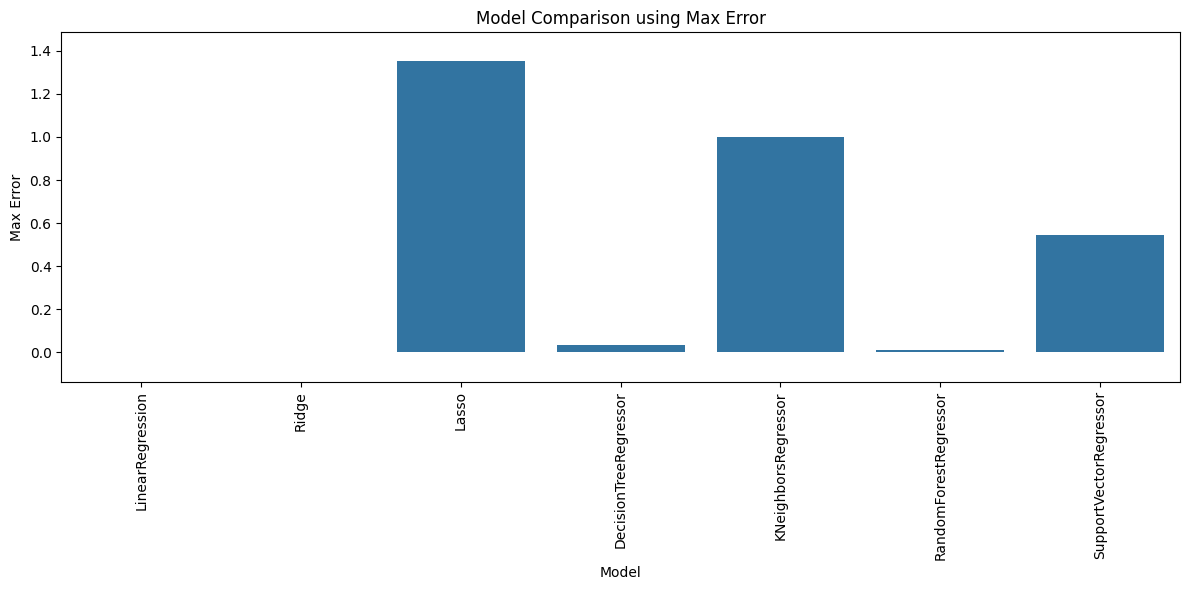

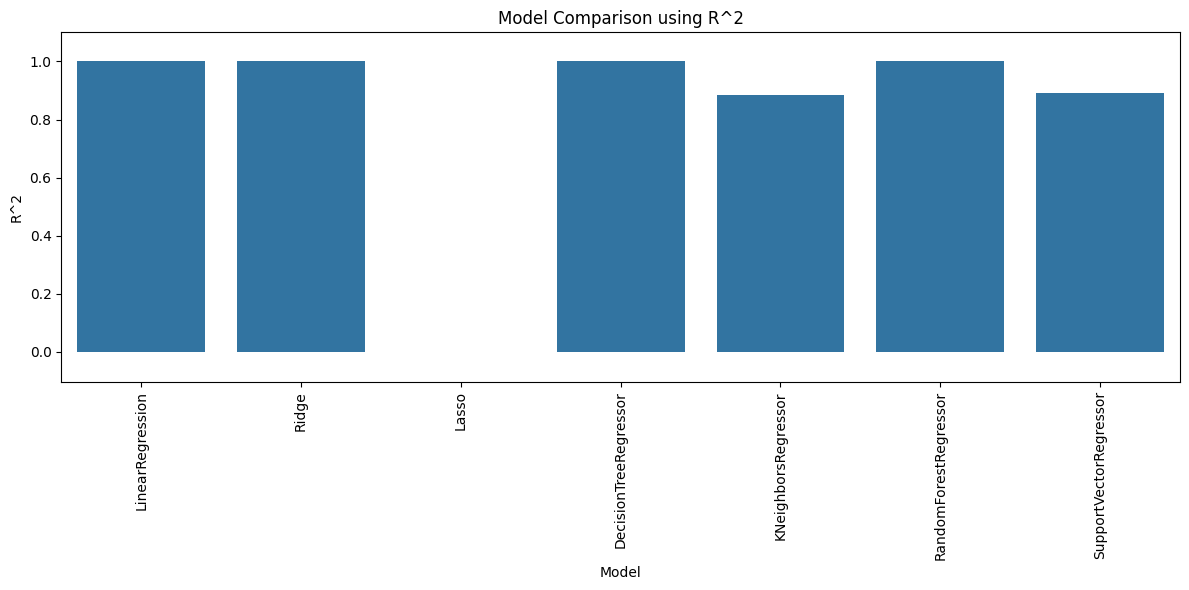

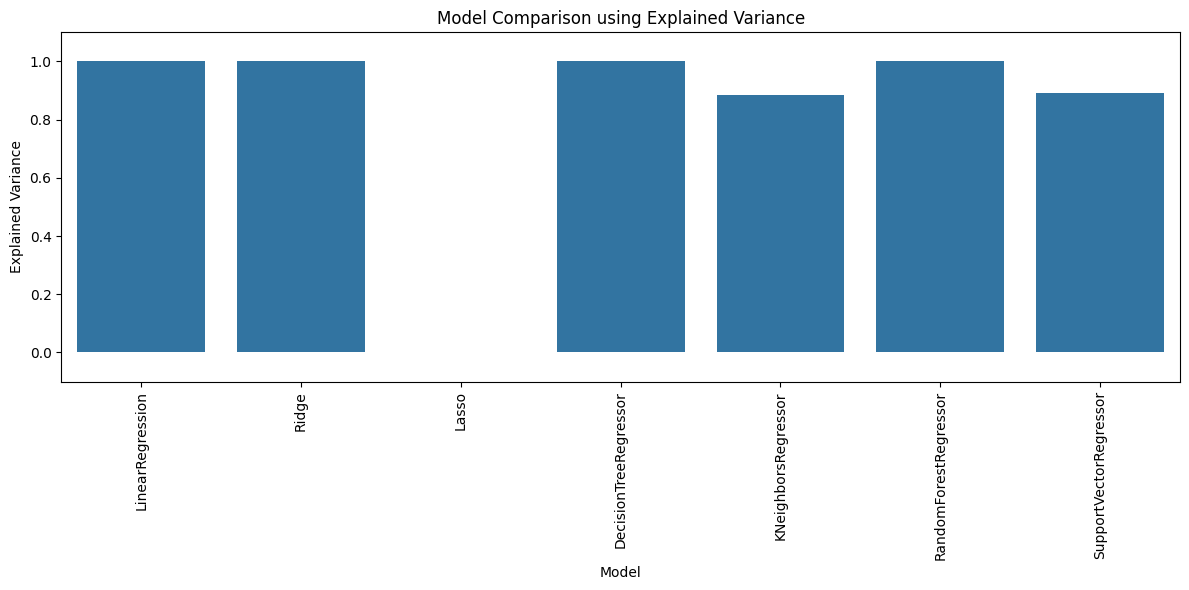

Best Model is: LinearRegression


In [54]:
X_train, X_test, y_train, y_test = split_data_train_test(train, target_feature)
models_result = run_models(models, X_train, X_test, y_train, y_test)
best_model = get_best_model(models_result, models, 'Mean Squared Error')
plot_models_results(models_result, 'Mean Squared Error')
plot_models_results(models_result, 'Mean Absolute Error')
plot_models_results(models_result, 'Max Error')
plot_models_results(models_result, 'R^2')
plot_models_results(models_result, 'Explained Variance')
print('Best Model is:', best_model.__class__.__name__)

<a id="step-4"></a>
# <div style="background-color: #CE5A67; color:white; font-family:Arial; text-align:center; border-radius:15px;">Step 4: Build final model and piplines with results submission</div>
<p>This step will conclude with building the final model and piplines then running results on test dataset followed by submissions</p>

In [1]:


target_feature = "SalePrice"

# ---------------------------
# 1. Helper Functions
# ---------------------------

def generate_summary_table(df):
    return pd.DataFrame({
        'column': df.columns,
        'dtype': df.dtypes.astype(str),
        'null %': df.isnull().mean() * 100
    })

def fill_missings(df):
    df = df.copy()
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna(df[col].mode()[0])
        else:
            df[col] = df[col].fillna(df[col].median())
    return df

def replace_inf(df):
    df = df.copy()
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df

def fill_na(df):
    return df.fillna(0)

def drop_feature(df, col):
    if col in df.columns:
        df = df.drop(columns=[col])
        return df, None
    else:
        return df, None

def encode_str_features(df):
    df = df.copy()
    le = LabelEncoder()
    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = le.fit_transform(df[col].astype(str))
    return df

def add_columns(df):
    df = df.copy()
    # Example engineered column
    if "AveRooms" not in df.columns and "AveBedrms" in df.columns:
        df["Rooms_per_Bedroom"] = df["AveRooms"] / (df["AveBedrms"] + 1)
    return df

def get_skewed_features(df):
    numeric = df.select_dtypes(include=[np.number]).columns
    skewed = []
    non_skewed = []
    for col in numeric:
        if col != target_feature:
            if abs(df[col].skew()) > 0.75:
                skewed.append(col)
            else:
                non_skewed.append(col)
    return skewed, non_skewed

def transform_skewed_features(df, cols):
    df = df.copy()
    for col in cols:
        df[col] = np.log1p(df[col].abs())
    return df

def transform_non_skewed_features(df, cols):
    df = df.copy()
    # currently do nothing, but kept for structure
    return df

def split_data_X_y(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    return X, y

def feature_selection(X, y, method):
    scores = method(X, y)
    df = pd.DataFrame({"Feature": X.columns, "Score": scores})
    df = df.sort_values(by="Score", ascending=False)
    return df.head(30)  # select best 30 features

def split_data_train_test(df, target):
    X, y = split_data_X_y(df, target)
    return train_test_split(X, y, test_size=0.2, random_state=42)

